# 1. 狮子、老虎和熊

我们参观野生动物园保护区，看到了3只狮子、2只老虎和1头熊，如果我们观察到任何动物的机会均等，那么动物园所有动物中，狮子、老虎和熊的占比各是多少？  
先验分布可以假定每种动物的占比是一样的，但各类动物占比不是独立的，所有的占比之和为1。可以用狄利克雷分布来建模。

## 1.1 狄利克雷分布

**狄利克雷分布**$Dir(\alpha)$ , 是一组$k$个连续多元随机分布的分布族，这组多元连续分布随机变量的参数为$\mathbf{a}=(\alpha_{1}, \alpha_{2}, \cdots, \alpha_{k})$，$\alpha_{i}\geq0$。它是贝塔（$\mathrm {B} $）分布在多元维度上的推广，也被称为多元贝塔布(MBD)。在贝叶斯理论中，狄利克雷分布是分类分布和多项式分布的共轭先验分布，因此常被用作先验分布。狄利克雷分布的密度函数为：

$$f\left( {{x}_{1}},\cdots ,{{x}_{k}};{{\alpha }_{1}},\cdots ,{{\alpha }_{k}} \right)=\dfrac{1}{\mathrm {B}\left( \alpha  \right)}\prod\limits_{i=1}^{K}{x_{i}^{{{\alpha }_{i}}-1}}$$

且对于所有$i\in [1,K]$，满足以下条件：

$$\left\{ \begin{matrix}
   \sum\limits_{i=1}^{k}{{{x}_{i}}=1}  \\
   {{x}_{i}}\ge 0  \\
   {{\alpha }_{i}}\ge 0  \\
\end{matrix} \right.
$$

其中归一化常数$\mathrm {B}$为：

$${\displaystyle \mathrm {B} ({\boldsymbol {\alpha }})={\frac {\prod _{i=1}^{K}\Gamma (\alpha _{i})}{\Gamma \left(\sum _{i=1}^{K}\alpha _{i}\right)}},{\boldsymbol {\alpha }}=(\alpha _{1},\ldots ,\alpha _{K})}$$

## 1.2 边缘分布共轭分布

狄利克雷分布的**边缘分布**是贝塔分布：
$${\displaystyle X_{i}\sim \operatorname {Beta} (\alpha _{i},\alpha _{0}-\alpha _{i})} \qquad \qquad(1)$$其中，$$\displaystyle{\alpha_0 = \sum_1^k \alpha_i}$$

狄利克雷分布是分类分布和多项式分布的共轭先验分布。这意味着，如果**随机变量**$X$服从分类分布或多项式分布，并且该**分布的参数**$\mathbf{a}$的先验分布服从狄利克雷分布，则该**参数**$\mathbf{a}$的后验分布也服从狄利克雷分布。即，如果：
$${\displaystyle {\begin{array}{rcccl}{\boldsymbol {\alpha }}&=&\left(\alpha _{1},\ldots ,\alpha _{K}\right)&=&{\text{先验参数}}\\\mathbf {p} \mid {\boldsymbol {\alpha }}&=&\left(p_{1},\ldots ,p_{K}\right)&\sim &\operatorname {Dir} (K,{\boldsymbol {\alpha }}) &=& \text{先验分布}\\
\mathbb {X} \mid \mathbf {p} &=&\left(\mathbf {x} _{1},\ldots ,\mathbf {x} _{K}\right)&\sim &\operatorname {Cat} (K,\mathbf {p} ) &=& \text{似然函数} \end{array}   } } $$
则以下结论成立：
$${\displaystyle {\begin{array}{rcccl}\mathbf {c} &=&\left(c_{1},\ldots ,c_{K}\right)&=&{\text{各类别出现的次数 }}i\\
\mathbf {p} \mid \mathbb {X} ,{\boldsymbol {\alpha }}&\sim &\operatorname {Dir} (K,\mathbf {c} +{\boldsymbol {\alpha }})&=&\operatorname {Dir} \left(K,c_{1}+\alpha _{1},\ldots ,c_{K}+\alpha _{K}\right) \qquad (2)\end{array}}}$$

# 1.3 类Dirichlet

In [1]:
from tools import Beta, MakePmfFromItems, MakePmfFromDict
import numpy

class Dirichlet(object):
    """狄利克雷分布模型。
    """
    
    def __init__(self, n, conc=1, name=''):
        """初始化狄利克雷分布
        n: 维度
        conc: 初始的种群占比参数
        name: 实例的名称
        """
        if n < 2:
            raise ValueError('狄利克雷分布的维数应当大于或等于2')

        self.n = n
        self.params = numpy.ones(n, dtype=numpy.float) * conc
        self.name = name

    def Update(self, data):
        """更新分布。这里仅需将参数简单相加，见公式（2）。
        
        data: 观测值构成的列表，与对应参数顺序保持一致。"""
        m = len(data)
        self.params[:m] += data

    def Random(self):
        """从分布生成随机变量。gamma抽样。

        Returns:归一化向量（列表）
        """
        p = numpy.random.gamma(self.params)
        return p / p.sum()

    def Likelihood(self, data):
        """似然函数。
        从分布组合中选择一个随机的概率向量，见下节。
        
        Returns: 概率值
        """
        m = len(data)
        if self.n < m:
            return 0

        x = data
        p = self.Random()
        q = p[:m] ** x
        return q.prod()

    def LogLikelihood(self, data):
        """对数似然分布.

        Returns: 对数概率值。
        """
        m = len(data)
        if self.n < m:
            return float('-inf')

        x = self.Random()
        y = numpy.log(x[:m]) * data
        return y.sum()

    def MarginalBeta(self, i):
        """计算第i个元分布的边际分布（Beta分布）.

        i: int
        Returns: Beta分布
        """
        alpha0 = self.params.sum()
        alpha = self.params[i]
        # Beta是在tools中定义的一个类
        return Beta(alpha, alpha0 - alpha)

    def PredictivePmf(self, xs, name=''):
        """Makes a predictive distribution.

        xs: values to go into the Pmf

        Returns: Pmf that maps from x to the mean prevalence of x
        """
        alpha0 = self.params.sum()
        ps = self.params / alpha0
        return MakePmfFromItems(zip(xs, ps), name=name)

+ Dirichlet类的__init__()方法的初始化功能很简单，只需要指定维度并给出集中度参数即可，很多计算是通过对参数完成，不需要生成每个随机变量取值对应的概率值。如果需要，$Beta$类提供了概率质量字典的方法。
+ （1）式已经指出，狄利克雷分布的边缘分布是Beta分布，利用这个性质，可以直接用参数计算各种群占比的后验分布。Dirichlet类的MarginalBeta方法用于计算边缘分布。
+ 狄利克雷分布是分类分布和多项式分布的共轭先验分布，因此在Update方法中只需将参数简单相加即可。
+ Likelihood方法和Random方法主要用于下节的分层版本狄利克雷种群密度模型，后面再介绍。

# 1.4 种群密度的后验分布

In [2]:
dirichlet = Dirichlet(3)
names = ['狮子','老虎','熊']
for i in range(3):
    beta = dirichlet.MarginalBeta(i)
    print(F"{names[i]}的占比的先验分布均值为:{beta.Mean():.02}。")


狮子的占比的先验分布均值为:0.33。
老虎的占比的先验分布均值为:0.33。
熊的占比的先验分布均值为:0.33。


狄利克雷分布是分类分布和多项式分布的共轭先验分布，因此在Update方法中只需将参数简单相加即可。结果如下：

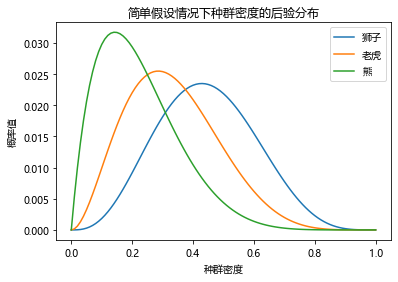

In [3]:
data = [3,2,1]
dirichlet.Update(data)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
for i in range(3):
    beta = dirichlet.MarginalBeta(i)
    beta_pmf = beta.MakePmf()
    
    x,y = zip(*beta_pmf.Items())
    plt.plot(x,y,label=names[i])   

plt.title("简单假设情况下种群密度的后验分布")
plt.xlabel('种群密度')
plt.ylabel('概率值')
plt.legend()
plt.show()

# 2. 分层版本的种群分布

现在，我们将问题升级。前面的例子，我们只假定保护区只有3种动物，这显然不符合现实。现在我们要考虑保护区还有其他动物的情况下，狮子、老虎和熊的占比是多少？
这个问题，我们可以分解为通过两个层次：第一个层次，保护区有多少种动物？第二个层次，各类动物的占比是多少？对此，我们需要通过多个层次进行建模。

+ 第一层是Species类，对种群数量建横。
+ 第二层是第1节中的Dirichlet类，在种群数量为$k$的前提下，计算各种群占比的分布。
的Suite对象，最上层的Suite对象代表种群数量，它的各个假设也是Suite对象，代表各个种群的占比。

## 2.1 Species类

In [4]:
from tools import Suite,Pmf,BinomialCoef
class Species(Suite):
    """种群数量"""
    
    def __init__(self, ns, conc=1, iters=1000):
        """
        ns: 种群数量可能的取值列表，大于等于已观测到种群数量。
        iters: 样本抽样的次数。
        """
        # 第二层模型。
        hypos = [Dirichlet(n, conc) for n in ns]
        # 均匀先验分布
        Suite.__init__(self, hypos)        
        self.iters = iters

    def Update(self, data):
        """更新数据。需要同时对每一层、第二层的模型进行更新，
        两层模型的更新方法各不相同

        data: 观测到的物种频率构成的列表。
        """
        # 调用父类中的Update方法，它将调用本类中的Likelihood方法
        # 更新第一层，数量的概率
        Suite.Update(self, data)

        # 更新下层的Suite对象，在种群数为n的条件下，种群的占比
        for hypo in self.Values():
            hypo.Update(data)

    def Likelihood(self, data, hypo):
        """当前假设下的似然函数

        hypo: Dirichlet对象
        data: 观测到的种群频率列表
        """
        dirichlet = hypo  # Direichlet对象

        # draw sample Likelihoods from the hypothetical Dirichlet dist
        # and add them up
        like = 0
        for _ in range(self.iters):
            like += dirichlet.Likelihood(data)

        # correct for the number of ways the observed species
        # might have been chosen from all species
        m = len(data)
        like *= BinomialCoef(dirichlet.n, m)

        return like

    def DistN(self):
        """计算种群数量n的分布字典."""
        pmf = Pmf()
        for hypo, prob in self.Items():
            pmf.Set(hypo.n, prob)
        return pmf

Species类的核心依然是第一层的似然函数，计算似然值步骤如下：
1. 以狄利克雷分布的先验参数$\mathbf{\alpha}$为参数，生成$\gamma$分布样本$(p_1,p_2,\cdots,p_n)$。根据多次抽样，取平均数。（Dirichlet.Random()）
2. 利用观测数据$(x_1,x_2,\cdots,x_k)$计算多项式$p^{x_1}p^{x_2}\cdots p^{x_k}$。未被更新部分（大于$k$的那一部分）观测样本数视作0。(Dirichlet.Likelihood())
3. 计算${\displaystyle C_n^k}$,并将计算结果与第2步结果相乘。(Species.Likelihood())

## 2.2 种群数量的后验分布

In [5]:
data = [3,2,1]
ns = range(3,30)
species = Species(ns,iters=2000)
species.Update(data)

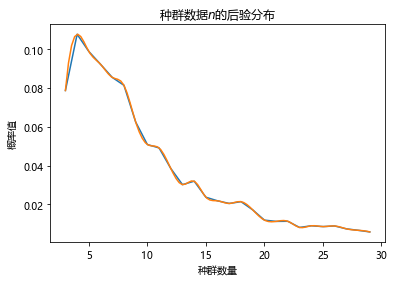

In [6]:
n_pmf = species.DistN()

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

plt.figure(figsize=(6,4))
x,y = zip(*n_pmf.Items())
f2 = interp1d(x, y, kind='cubic')
x2 = numpy.linspace(min(x),max(x),100)
y2 = f2(x2)
plt.plot(x,y,'-',x2,y2,'-') 
plt.title("种群数据$n$的后验分布")
plt.xlabel('种群数量')
plt.ylabel('概率值')
plt.show()

## 2.3 种群密度的后验分布

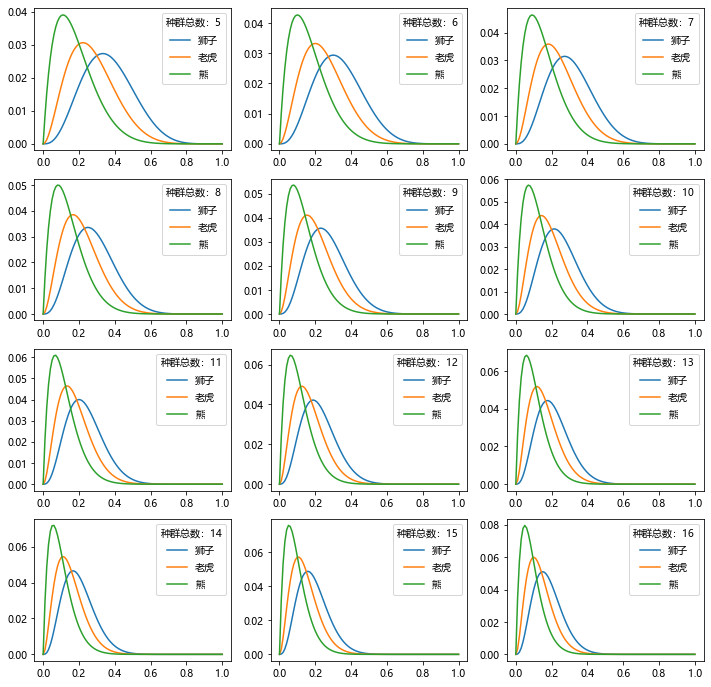

In [52]:
plt.figure(figsize=(12,12))
for i in range(12):
    drt = list(species.Items())[i+2][0]  
    ax = plt.subplot(4,3,i+1)
    for j in range(3):
        beta = drt.MarginalBeta(j)
        beta_pmf = beta.MakePmf()    
        x,y = zip(*beta_pmf.Items())
        ax.plot(x,y,label=names[j]) 
    ax.legend(title=F'种群总数：{drt.n}')
plt.show()

本文例子来自Allen B. Downey的《Think Bayes》一书，内容作了增补和修改。有关贝叶斯统计模型的更多例子及完整源代码请访问[GitHub](https://github.com/HuRongxing/thinkbayes)。`